# RCNN classique
### Entrainement sur un dataset d'avion

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## 1- Récupération des images et des ansotations

In [2]:
path = ".\\data\\Images\\Images"
annot = ".\\data\\Airplanes_Annotations\\Airplanes_Annotations"

#### Visualisation des données

In [3]:
print(f"Nombre d'images: {len(os.listdir(path))}")
print(f"Nombre d'annotations: {len(os.listdir(annot))}")

first_annot_file = os.listdir(annot)[0]
#on split le nom du fichier en csv pour enlever l'extention .csv et on y ajoute l'extension .jpg pour trouver l'image associée
#filename est le nom de l'image associée au fichier d'anotations i
first_image_file = first_annot_file.split(".")[0]+".jpg"

first_annot_path = os.path.join(annot, first_annot_file)
first_image_path = os.path.join(path, first_image_file)

first_annot = pd.read_csv(first_annot_path)
first_image = cv2.imread(first_image_path) #parametre de cv2.imread :  A string representing the path of the image to be read.


print(f"\nExemple première annotation de {first_image_file} ({first_annot.shape[0]} rectangles) :")
first_annot.head()

Nombre d'images: 733
Nombre d'annotations: 733

Exemple première annotation de 42845.jpg (4 rectangles) :


,4
0,15 69 40 96
1,10 173 42 203
2,74 212 100 243
3,233 197 256 226


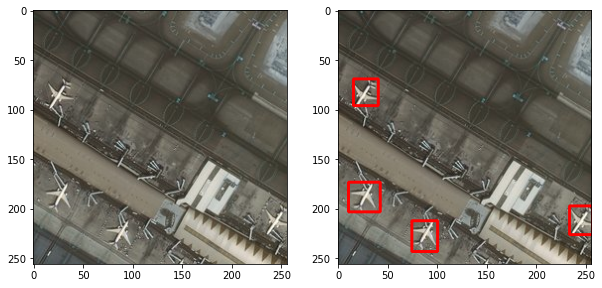

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(first_image)
plt.subplot(122)


first_image_with_rect = first_image.copy()
#chaque row contient les coordonnées x1,y1 et x2,y2 du rectangle de la bouding box
for row in first_annot.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    #on dessine sur l'image img un rectangle qui part du point (x1,y1) jusqu'au point (x2,y2), couleur rouge : (255,0,0) et d'épaisseur 2
    cv2.rectangle(first_image_with_rect,(x1,y1),(x2,y2),(255,0,0), 2)
# plt.figure()
plt.imshow(first_image_with_rect)
plt.show()




## 2- Selective search 

#### Essai sur la première image

In [5]:
#The function turns on or off the optimized code in OpenCV
cv2.setUseOptimized(True);

#initialise selective search
#Selective search segmentation algorithm
#Selective Search is one of the most popular Region Proposal algorithms
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

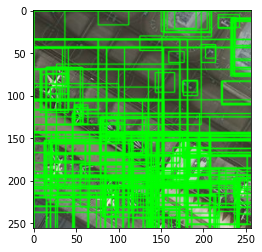

In [6]:
ss.setBaseImage(first_image)

#Initialize the class with the 'Selective search fast' parameter
ss.switchToSelectiveSearchFast()

#Based on all images, graph segmentations and stragies, computes all possible rects and return them.
rects = ss.process()

first_image_with_ss = first_image.copy()

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(first_image_with_ss, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(first_image_with_ss)
plt.show()

In [7]:
train_images=[]
train_labels=[]

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
# Comprend pas trop pourquoi on le refait alors qu'on l'avait déjà 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#### Récupération de sous-image contenant des objets et n'en contenant (par rapport au annotations)
Contient: positive          &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;1 dans train_labels<br>
Ne contient pas: négatif    &ensp;&ensp;&ensp;0 dans train_labels

Seuil iuo pour distinguer à définir
Les sous-image sont recadrées 

In [11]:
# On remplit train images et train labels avec des régions d'images en images et 1 ou 0 pour savoir si c'est une bonne bb ou pas

NB_BBOX_POSITIVE = 30
NB_BBOX_NEGATIVE = 30

SEUIL_BBOX_POSITIVE = 0.7
SEUIL_BBOX_NEGATIVE = 0.3

IMAGE_SIZE = (224,224)

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            annotations = pd.read_csv(os.path.join(annot,i))

            #dans gtvalues, y aura les coordonnées des bb réélles 
            true_rects=[]
            for row in annotations.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                true_rects.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()

            # getting proposed regions 
            ssresults = ss.process()
            imout = image.copy()

            #compteur des "foreground images" 
            counter = 0
            
            # compteur des "background images" 
            falsecounter = 0

            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0: # max 2000 regions (bbox) par image

                    #pour chaque vraie bb
                    for true_rect in true_rects:
                        #coordonnées de la bb à tester
                        x,y,w,h = result
                        iou = get_iou(true_rect,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        #on veut que 30 positives areas
                        if counter < NB_BBOX_POSITIVE:
                            #on veut que les bb avec un iou>0.7
                            if iou > SEUIL_BBOX_POSITIVE:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            #sert à dire que on a assez d'areas foreground
                            fflag = 1
                        #on veut que 30 negatives areas
                        if falsecounter < NB_BBOX_NEGATIVE:
                            #on veut que les bb avec iou <0.3
                            if iou < SEUIL_BBOX_NEGATIVE:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            #sert à dire que on a assez d'areas background
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

# A la fin, on a rempli les listes train_images et train_labels


17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

KeyboardInterrupt: 

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
print(X_new.shape)
print(f"Nombre de sous image: {X_new.shape[0]}")
print(f"Sous images de taille: {X_new.shape[1]}x{X_new.shape[2]} avec {X_new.shape[3]} canaux")

(30229, 224, 224, 3)
Nombre de sous image: 30229
Sous images de taille: 224x224 avec 224 canaux


## 3- Classification et détection

### 3.1- Création du modèle

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#### Récupération d'un modèle pré-entrainé

In [ ]:
# VGG16 – Convolutional Network for Classification and Detection

vggmodel = VGG16(weights='imagenet', include_top=True)
#include_top: whether to include the 3 fully-connected layers at the top of the network
#weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded

# vggmodel.summary()
print(f"Nombre de couche: {len(vggmodel.layers)}")

Nombre de couche: 23


#### On gèle les poids des premières couches pour n'entrainer (fine tune) que les dernières

In [ ]:
# [:15] --> couches 0 à 14
# Freeze convolution blocks 
for layers in (vggmodel.layers)[:15]:
    # print(layers)
    layers.trainable = False

#### Modification de la couche de sortie
Couche de sortie d'imagenet: 1000 <br>
Couche de sortie voulu pour détecter des avions: 2

In [ ]:
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
# 2 : dimension de l'output ?

In [ ]:
# Arguments
# inputs: The input(s) of the model: a keras.Input object or list of keras.Input objects.
# outputs: The output(s) of the model. See Functional API example below.
model_final = Model(vggmodel.input, predictions)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Algo d'optimisation Adam : formation de modèles d'apprentissage profond
#                            extension de la descente de gradient stochastique
#                            utilisation des moyennes courantes des gradients et des seconds moments des gradients
#                            utilisé pour calculer les taux d'apprentissage adaptatifs pour chaque paramètre
opt = Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
# model_final.summary()

### 3.2- Préparation des données d'entrainement

In [ ]:
from sklearn.model_selection import train_test_split

#sert à faire du one hot encoding 
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        # y_type_str
        # Represents the type of the target data as evaluated by utils.multiclass.type_of_target. 
        # Possible type are ‘continuous’, ‘continuous-multioutput’, ‘binary’, ‘multiclass’, ‘multiclass-multioutput’, 
        # ‘multilabel-indicator’, and ‘unknown’.  
        if self.y_type_ == 'binary':
            # np.hstack : Stack arrays in sequence horizontally (column wise).
            # parametre : sequence of ndarrays.The arrays must have the same shape along all but the second axis, except 1-D arrays which can be any length.
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new) # le 0 de y_new est transformé en [0 1] dans Y et le 1 de y_new est transformé en [1 0] en Y

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [ ]:
# ImageDataGenerator : Generate batches of tensor image data with real-time data augmentation.
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

## 3.3- Entrainement du modèle

In [ ]:
EPOCHS = 100
STEP_PER_EPOCH = 10

hist = model_final.fit_generator(generator= traindata, steps_per_epoch= STEP_PER_EPOCH, epochs= EPOCHS, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

#### Visualiation de l'entrainement

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
# plt.savefig('chart loss.png')

#### Essai sur une image dans test

In [ ]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        plt.show()